In [1]:
import numpy as np
import torch
np.random.seed(2022254)
torch.manual_seed(2022254)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: krishna22254 (krishna22254-indraprastha-institute-of-information-techn). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Preparing the dataset...
Performing stratified split for train and validation sets...
Creating DataLoader for training and validation sets...
Starting the training loop...
Epoch [1/10]
Training Loss: 1.8222714085609486, Training Accuracy: 33.9404328262267%
Validation Loss: 1.4615071140802824, Validation Accuracy: 48.628963153384746%
Epoch [2/10]
Training Loss: 1.327855062408325, Training Accuracy: 53.65331047782301%
Validation Loss: 1.2554434958176734, Validation Accuracy: 55.955441302485006%
Epoch [3/10]
Training Loss: 1.0496267084127817, Training Accuracy: 63.61688450824941%
Validation Loss: 1.133130894257472, Validation Accuracy: 61.18251928020565%
Epoch [4/10]
Training Loss: 0.8240365635317105, Training Accuracy: 71.57703021212771%
Validation Loss: 1.058927901280232, Validation Accuracy: 62.89631533847472%
Epoch [5/10]
Training Loss: 0.5975593140778633, Training Accuracy: 79.4514677523034%
Validation Loss: 0.9178030999043049, Validation Accuracy: 71.59383033419023%
Epoch [6/10]
Tra

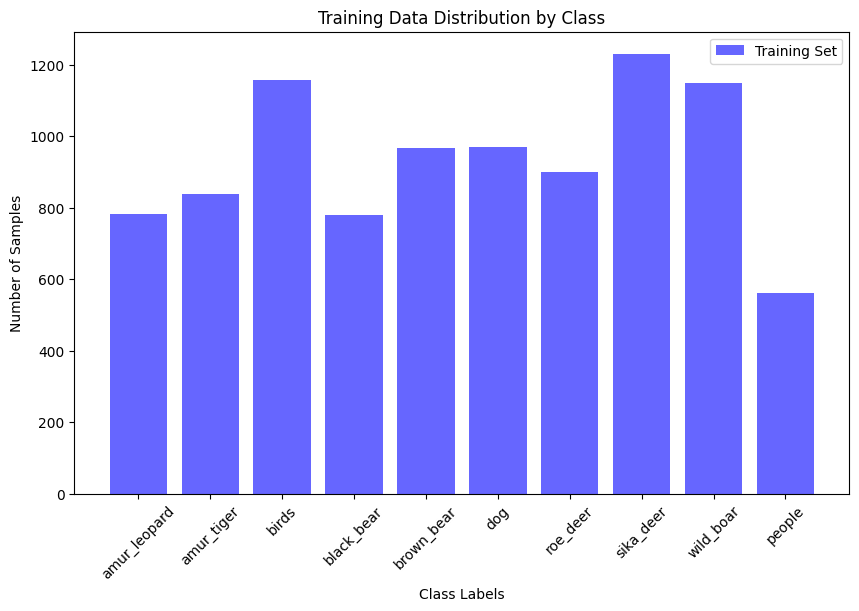

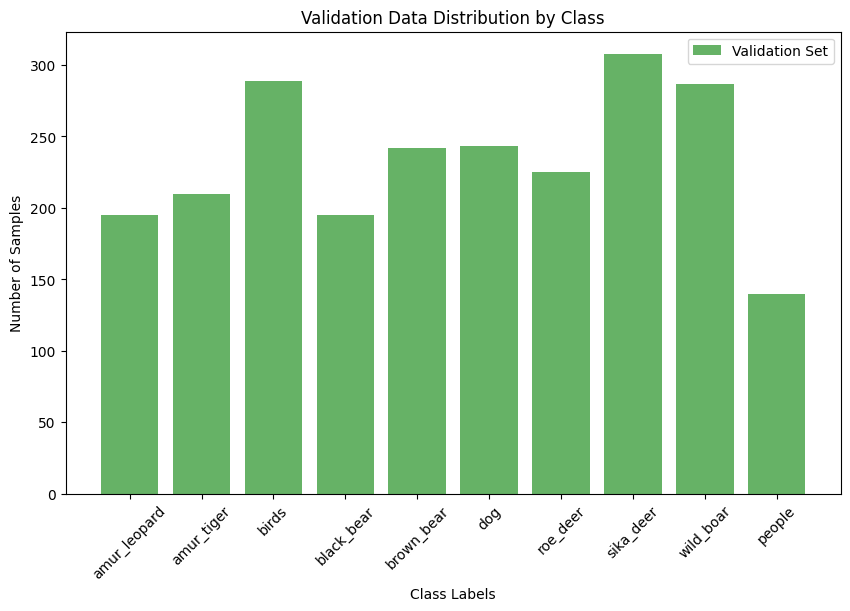

Plotting training and validation loss...


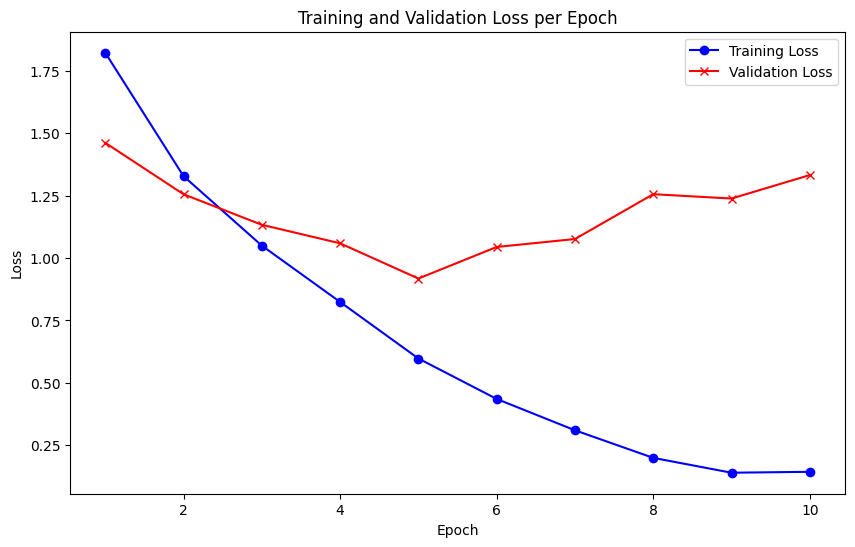

Evaluating the model on the validation set...


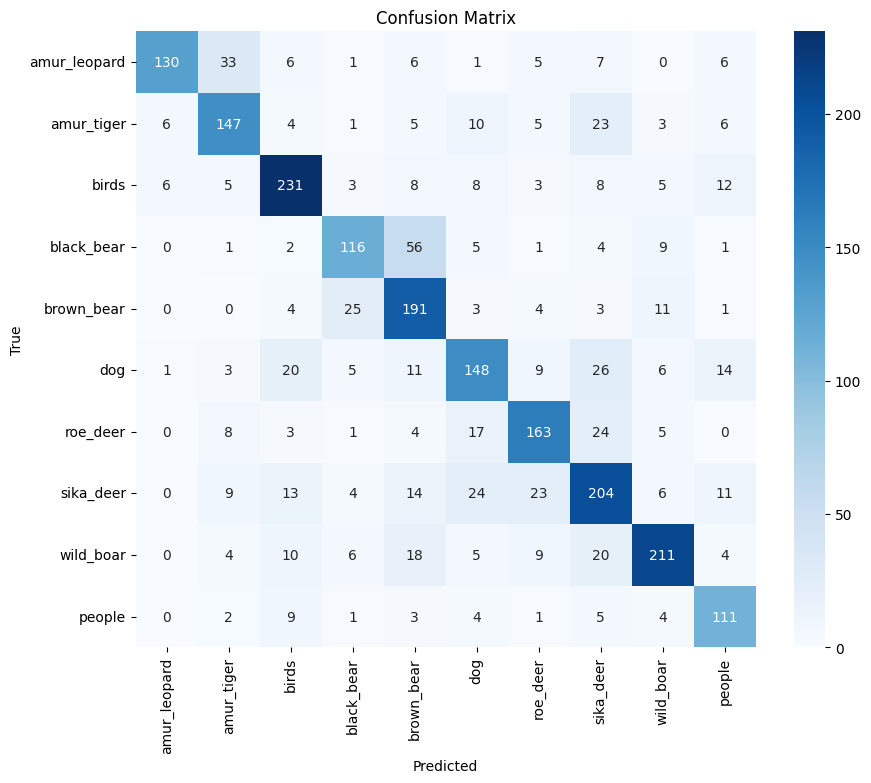

Saving the trained model weights...


f1_score,▁
train_accuracy,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▃▅▅█▆████
val_loss,█▅▄▃▁▃▃▅▅▆
f1_score,0.70844
train_accuracy,95.18963
train_loss,0.14376
val_accuracy,70.77978
val_loss,1.3323


In [2]:
import os
import shutil
import numpy as np  
from sklearn.model_selection import train_test_split
from collections import Counter
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms
import wandb
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

wandb.login(key="794588cf38c96c1c7a44832a705b3af127273a99")  
run = wandb.init(project="wildlife-classification",  config={ "learning_rate": 0.001, "epochs": 10, "batch_size": 30 })

class_labels = { 'amur_leopard': 0, 'amur_tiger': 1, 'birds': 2, 'black_bear': 3, 'brown_bear': 4, 'dog': 5, 'roe_deer': 6, 'sika_deer': 7, 'wild_boar': 8, 'people': 9}
dataset_dir = Path('/kaggle/input/russian-wildlife/Cropped_final')

# Step 1: Preparing the dataset
print("Preparing the dataset...")
class_name_iter = iter(class_labels.items())
image_paths = []

count=0
labels = []

class_name, label = next(class_name_iter, (None, None))  
while class_name is not None:
    class_folder = dataset_dir / class_name
    img_names = os.listdir(class_folder)
    count+=1
    img_index = 0
    while img_index < len(img_names):
        img_name = img_names[img_index]
        image_paths.append(str(class_folder / img_name))
        labels.append(label)
        count+=1
        img_index += 1
    
    class_name, label = next(class_name_iter, (None, None)) 

image_paths = np.array(image_paths)
labels = np.array(labels)
label=labels

# Step 2: Stratified split for train and validation
print("Performing stratified split for train and validation sets...")
x=2
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Step 3: Dataset class
class WildlifeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Step 4: Image Transformations
transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])])

# Step 5: DataLoaders for training and validation sets
print("Creating DataLoader for training and validation sets...")
train_dataset = WildlifeDataset(train_paths, train_labels, transform=transform)
val_dataset = WildlifeDataset(val_paths, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)

# Step 6: CNN Architecture
class CNN_Model(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.dropout = nn.Dropout(0.3)  

        self.fc_input_size = 128 // 4 // 2 // 2
        self.fc_input_size = self.fc_input_size * self.fc_input_size * 128
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(-1, self.fc_input_size)
        x = self.relu(self.fc1(x))
        
        # x = self.dropout(x)
        
        x = self.fc2(x)
        return x

#Step 7: Initializing the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_classes=10)
model.to(device)

# Step 8: Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 9: Training loop
print("Starting the training loop...")
epoch = 0

# Track losses for plotting
train_losses = []
val_losses = []

time=0
while epoch < 10:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    count=0

    train_iter = iter(train_loader)  
    while True:
        try:
            images, labels = next(train_iter)
        except StopIteration:
            break  
        
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        count+=1
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        time+=count
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    total_test=0

    model.eval()
    with torch.no_grad():
        val_iter = iter(val_loader)  
        while True:
            try:
                images, labels = next(val_iter)
            
            except StopIteration:
                break  

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_test+= loss.item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    new=0

    epoch += 1

    # Log losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/10]")
    print(f"Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}%")
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}%")

    wandb.log({ "train_loss": avg_train_loss, "train_accuracy": train_accuracy, "val_loss": avg_val_loss, "val_accuracy": val_accuracy  })

# Step 10: Data Distribution Visualization
print("Visualizing data distribution...")

# Visualize the data distribution in the training and validation sets
train_dist = Counter(train_labels)
val_dist = Counter(val_labels)

# Plot training data distribution
plt.figure(figsize=(10, 6))
plt.bar(train_dist.keys(), train_dist.values(), color='blue', alpha=0.6, label='Training Set')
plt.title('Training Data Distribution by Class')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(range(10), list(class_labels.keys()), rotation=45)
plt.legend()
plt.show()

# Plot validation data distribution
plt.figure(figsize=(10, 6))
plt.bar(val_dist.keys(), val_dist.values(), color='green', alpha=0.6, label='Validation Set')
plt.title('Validation Data Distribution by Class')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(range(10), list(class_labels.keys()), rotation=45)
plt.legend()
plt.show()

# Step 11: Loss Plots
print("Plotting training and validation loss...")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch+1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, epoch+1), val_losses, label='Validation Loss', color='red', marker='x')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 12: Evaluation on Validation Set
print("Evaluating the model on the validation set...")
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Step 13: Confusion Matrix and F1-Score
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

# Log F1-Score to WandB
wandb.log({"f1_score": f1})

# Step 14: Save the trained model
# Step 14: Save the trained model (only the state_dict/weights)
print("Saving the trained model weights...")
torch.save(model.state_dict(), "convnet_weights.pth")


wandb.finish()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


Epoch [1/10]
Training Loss: 0.6626, Training Accuracy: 77.48%
Validation Loss: 0.3652, Validation Accuracy: 86.68%
Epoch [2/10]
Training Loss: 0.1943, Training Accuracy: 94.05%
Validation Loss: 0.3390, Validation Accuracy: 88.82%
Epoch [3/10]
Training Loss: 0.0920, Training Accuracy: 97.45%
Validation Loss: 0.3095, Validation Accuracy: 89.67%
Epoch [4/10]
Training Loss: 0.0574, Training Accuracy: 98.56%
Validation Loss: 0.3718, Validation Accuracy: 89.42%
Epoch [5/10]
Training Loss: 0.0608, Training Accuracy: 98.23%
Validation Loss: 0.3848, Validation Accuracy: 88.47%
Epoch [6/10]
Training Loss: 0.0410, Training Accuracy: 98.68%
Validation Loss: 0.3351, Validation Accuracy: 91.00%
Epoch [7/10]
Training Loss: 0.0273, Training Accuracy: 99.11%
Validation Loss: 0.3533, Validation Accuracy: 90.62%
Epoch [8/10]
Training Loss: 0.0501, Training Accuracy: 98.56%
Validation Loss: 0.4003, Validation Accuracy: 89.85%
Epoch [9/10]
Training Loss: 0.0407, Training Accuracy: 98.76%
Validation Loss: 0

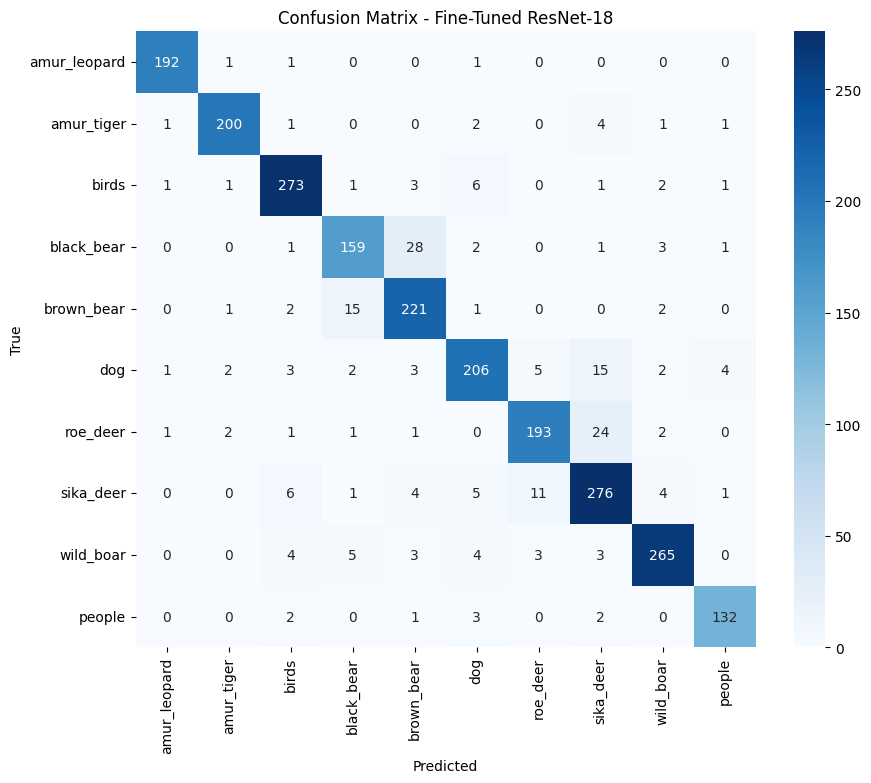

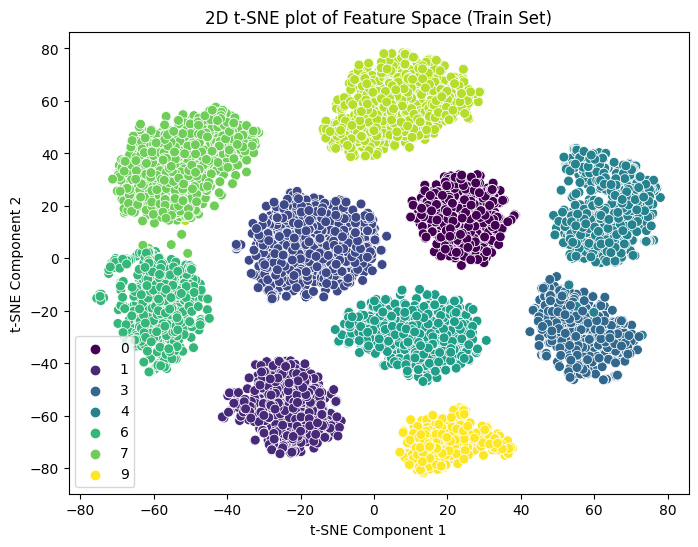

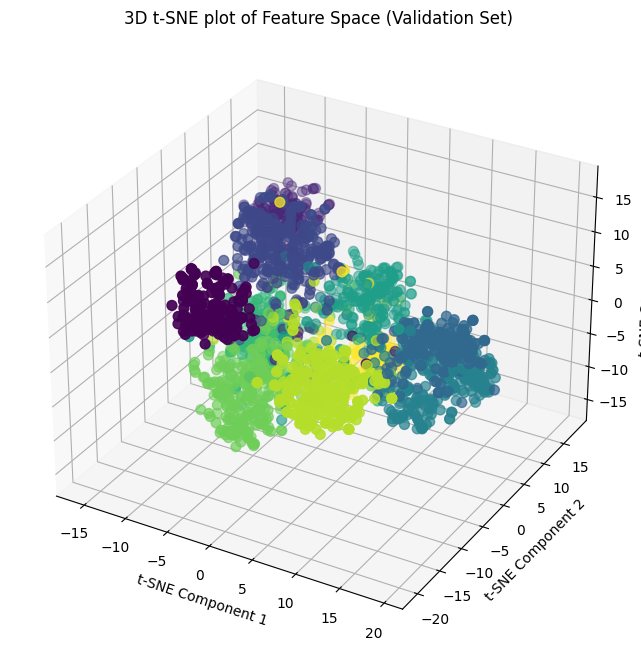

Saving the trained model...
Model weights saved to resnet_finetuned.pth


train_accuracy,▁▆▇███████
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▄▆▅▄█▇▆█▇
val_loss,▅▃▁▆▇▃▄█▅▆
train_accuracy,98.89651
train_loss,0.03644
val_accuracy,90.70266
val_loss,0.37812


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from torchvision import models, transforms
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from torch.utils.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D

# Initialize W&B
wandb.login(key="794588cf38c96c1c7a44832a705b3af127273a99")
run = wandb.init(project="wildlife-classification", config={ 
    "learning_rate": 0.0001, 
    "epochs": 10, 
    "batch_size": 30 
})

# Image transformations for ResNet-18
transform_resnet = transforms.Compose([ transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming you have already defined the WildlifeDataset class
train_dataset_resnet = WildlifeDataset(train_paths, train_labels, transform=transform_resnet)
val_dataset_resnet = WildlifeDataset(val_paths, val_labels, transform=transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=30, shuffle=True)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=30, shuffle=False)

# Fine-Tuned ResNet-18 Model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.resnet = models.ResNet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = ResNet18(num_classes=10)
model_resnet.to(device)

# Loss function and optimizer
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.0001)

# Training loop for fine-tuned ResNet-18
epoch = 0
classif=0
while epoch < 10:
    model_resnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    test_loss=0

    for images, labels in train_loader_resnet:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_resnet.zero_grad()
        outputs = model_resnet(images)
        classif+=1
        loss = criterion_resnet(outputs, labels)
        
        loss.backward()
        optimizer_resnet.step()
        test_loss+=loss.item()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train

    # Validation loop
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    test_loss+=val_loss

    model_resnet.eval()
    with torch.no_grad():
        for images, labels in val_loader_resnet:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet(images)
            loss = criterion_resnet(outputs, labels)
            test_loss+=loss.item()
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    avg_train_loss = running_loss / len(train_loader_resnet)
    avg_val_loss = val_loss / len(val_loader_resnet)

    epoch += 1

    print(f"Epoch [{epoch}/10]")
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Log metrics to W&B
    wandb.log({ 
        "train_loss": avg_train_loss, 
        "train_accuracy": train_accuracy, 
        "val_loss": avg_val_loss, 
        "val_accuracy": val_accuracy 
    })

# Report Accuracy and F1-Score on the Validation Set
all_labels = []
all_preds = []

model_resnet.eval()
with torch.no_grad():
    for images, labels in val_loader_resnet:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy_resnet = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Validation Accuracy: {accuracy_resnet:.4f}")
print(f"Validation F1-Score: {f1:.4f}")

# Log confusion matrix to W&B
cm_resnet = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fine-Tuned ResNet-18")

wandb.log({"confusion_matrix_resnet": wandb.Image(plt)})
plt.show()

# Feature extraction for t-SNE visualization
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for images, target_labels in dataloader:
            images = images.to(device)
            output = model.resnet.conv1(images)
            output = model.resnet.bn1(output)
            output = model.resnet.relu(output)
            output = model.resnet.maxpool(output)
            output = model.resnet.layer1(output)
            output = model.resnet.layer2(output)
            output = model.resnet.layer3(output)
            output = model.resnet.layer4(output)
            
            features.append(output.view(output.size(0), -1).cpu().numpy())  # Flatten the output
            labels.append(target_labels.cpu().numpy())

    return np.concatenate(features), np.concatenate(labels)

# Extract training features
train_features, train_labels = extract_features(model_resnet, train_loader_resnet)

# Perform t-SNE (2D and 3D visualization)
tsne = TSNE(n_components=2, random_state=42)
train_features_2d = tsne.fit_transform(train_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_features_2d[:, 0], y=train_features_2d[:, 1], hue=train_labels, palette="viridis", s=50)
plt.title("2D t-SNE plot of Feature Space (Train Set)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
wandb.log({"2d_tsne": wandb.Image(plt)})
plt.show()

# 3D t-SNE plot for the validation set
tsne_3d = TSNE(n_components=3, random_state=42)
val_features, val_labels = extract_features(model_resnet, val_loader_resnet)
val_features_3d = tsne_3d.fit_transform(val_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(val_features_3d[:, 0], val_features_3d[:, 1], val_features_3d[:, 2], c=val_labels, cmap="viridis", s=50)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.title("3D t-SNE plot of Feature Space (Validation Set)")
wandb.log({"3d_tsne": wandb.Image(fig)})
plt.show()

# Save the model after training (weights only)
print("Saving the trained model...")
model_save_path = 'resnet_finetuned.pth'
torch.save(model_resnet.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

# Finish W&B run
wandb.finish()


In [4]:
print(len(train_dataset))

9334


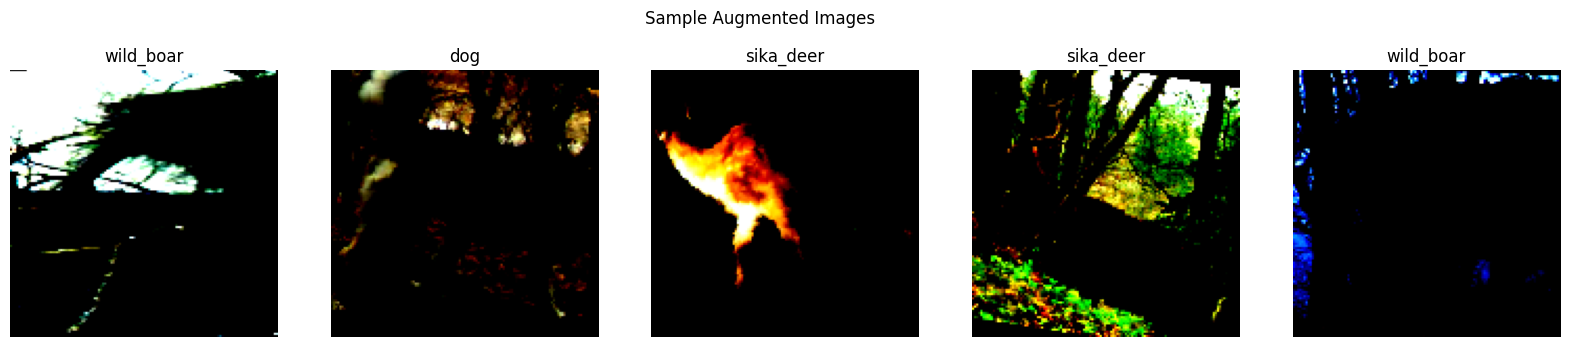

In [8]:
import os
import shutil
import numpy as np  
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.manifold import TSNE

import wandb

# # ---------------------------
# # 1. Data Preparation
# # ---------------------------

# # Use the mapping exactly as specified by the assignment.
# class_labels = { 
#     'amur_leopard': 0, 
#     'amur_tiger': 1, 
#     'birds': 2, 
#     'black_bear': 3, 
#     'brown_bear': 4, 
#     'dog': 5, 
#     'roe_deer': 6, 
#     'sika_deer': 7, 
#     'wild_boar': 8, 
#     'people': 9
# }

# # Update the dataset directory as needed (ensure that folder names match the keys above).
# dataset_dir = Path('/kaggle/input/russian-wildlife/Cropped_final')

# print("Preparing the dataset...")
# image_paths = []
# labels = []

# # For each class in the mapping, list images from the corresponding folder.
# for class_name, label in class_labels.items():
#     class_folder = dataset_dir / class_name  # Make sure folder names match (e.g., "amur leopard")
#     if not class_folder.exists():
#         print(f"Warning: Folder {class_folder} not found.")
#         continue
#     for img_name in os.listdir(class_folder):
#         image_paths.append(str(class_folder / img_name))
#         labels.append(label)

# image_paths = np.array(image_paths)
# labels = np.array(labels)

# # Stratified split: 80% train, 20% validation
# print("Performing stratified split for train and validation sets...")
# train_paths, val_paths, train_labels, val_labels = train_test_split(
#     image_paths, labels, test_size=0.2, stratify=labels, random_state=42
# )

# # Custom Dataset class
# class WildlifeDataset(Dataset):
#     def __init__(self, image_paths, labels, transform=None):
#         self.image_paths = image_paths
#         self.labels = labels
#         self.transform = transform
    
#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         label = self.labels[idx]
#         img = Image.open(img_path).convert('RGB')
#         if self.transform:
#             img = self.transform(img)
#         return img, label

# # ---------------------------
# # 1(b) DataLoaders for Original Transforms
# # ---------------------------
# # Transformation for training the CNN from scratch (without augmentation)
# transform_basic = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
# ])

# train_dataset = WildlifeDataset(train_paths, train_labels, transform=transform_basic)
# val_dataset = WildlifeDataset(val_paths, val_labels, transform=transform_basic)

# train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)

# # ---------------------------
# # 1(c) Visualize Data Distribution
# # ---------------------------
# print("Visualizing data distribution...")
# train_dist = Counter(train_labels)
# val_dist = Counter(val_labels)

# plt.figure(figsize=(10, 6))
# plt.bar(train_dist.keys(), train_dist.values(), color='blue', alpha=0.6, label='Training Set')
# plt.title('Training Data Distribution by Class')
# plt.xlabel('Class Labels')
# plt.ylabel('Number of Samples')
# plt.xticks(range(10), list(class_labels.keys()), rotation=45)
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.bar(val_dist.keys(), val_dist.values(), color='green', alpha=0.6, label='Validation Set')
# plt.title('Validation Data Distribution by Class')
# plt.xlabel('Class Labels')
# plt.ylabel('Number of Samples')
# plt.xticks(range(10), list(class_labels.keys()), rotation=45)
# plt.legend()
# plt.show()

# # ---------------------------
# # 2. Training a CNN from Scratch
# # ---------------------------
# wandb.login(key="794588cf38c96c1c7a44832a705b3af127273a99")
# run = wandb.init(project="wildlife-classification", config={
#     "learning_rate": 0.001,
#     "epochs": 10,
#     "batch_size": 30
# })

# # Updated CNN architecture with 3 convolution layers
# class CNN_Model(nn.Module):
#     def __init__(self, num_classes=10):
#         super(CNN_Model, self).__init__()
#         # First convolution: 32 feature maps
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
#         # Second convolution: 64 feature maps
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # Third convolution: 128 feature maps
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # Calculate flattened size (assuming input size 128x128)
#         # After pool1: 128/4 = 32, after pool2: 32/2 = 16, after pool3: 16/2 = 8
#         self.fc_input_size = 8 * 8 * 128
        
#         self.fc1 = nn.Linear(self.fc_input_size, 512)
#         self.fc2 = nn.Linear(512, num_classes)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.pool1(x)
#         x = self.relu(self.conv2(x))
#         x = self.pool2(x)
#         x = self.relu(self.conv3(x))
#         x = self.pool3(x)
#         x = x.view(-1, self.fc_input_size)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Initialize model, loss, and optimizer
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNN_Model(num_classes=10)
# model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# print("Starting CNN training...")
# epochs = 10
# train_losses = []
# val_losses = []

# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     correct_train = 0
#     total_train = 0
    
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct_train += (predicted == labels).sum().item()
#         total_train += labels.size(0)
    
#     train_accuracy = 100 * correct_train / total_train

#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     correct_val = 0
#     total_val = 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct_val += (predicted == labels).sum().item()
#             total_val += labels.size(0)
    
#     val_accuracy = 100 * correct_val / total_val
#     avg_train_loss = running_loss / len(train_loader)
#     avg_val_loss = val_loss / len(val_loader)
    
#     train_losses.append(avg_train_loss)
#     val_losses.append(avg_val_loss)
    
#     print(f"Epoch [{epoch+1}/{epochs}]")
#     print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
#     print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
#     wandb.log({
#         "train_loss": avg_train_loss,
#         "train_accuracy": train_accuracy,
#         "val_loss": avg_val_loss,
#         "val_accuracy": val_accuracy
#     })

# # (c) Analyze Loss Plots (print or add your comments in your report)
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
# plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='x')
# plt.title('Training and Validation Loss per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
# # -> Comment: If the validation loss is much higher than the training loss and diverges over epochs, then the model may be overfitting.

# # (d) Evaluation on the Validation Set: Accuracy, F1-Score, and Confusion Matrix
# all_labels = []
# all_preds = []
# model.eval()
# with torch.no_grad():
#     for images, labels in val_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(predicted.cpu().numpy())

# accuracy_cnn = accuracy_score(all_labels, all_preds)
# f1_cnn = f1_score(all_labels, all_preds, average="weighted")
# print(f"CNN Validation Accuracy: {accuracy_cnn:.4f}")
# print(f"CNN Validation F1-Score: {f1_cnn:.4f}")

# cm_cnn = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues",
#             xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix - CNN")
# wandb.log({"confusion_matrix_cnn": wandb.Image(plt)})
# plt.show()
# wandb.log({"cnn_f1_score": f1_cnn})

# # (e) Visualize Misclassified Images: For each class in the validation set, show 3 misclassified images
# misclassified = {}  # dictionary: true_class -> list of (image, predicted_class)
# model.eval()
# with torch.no_grad():
#     for img, true_label in val_dataset:
#         img_tensor = img.unsqueeze(0).to(device)
#         output = model(img_tensor)
#         _, pred_label = torch.max(output, 1)
#         if pred_label.item() != true_label:
#             if true_label not in misclassified:
#                 misclassified[true_label] = []
#             if len(misclassified[true_label]) < 3:
#                 misclassified[true_label].append((img, pred_label.item()))

# # Plot misclassified images per class
# for true_label, img_list in misclassified.items():
#     plt.figure(figsize=(12, 4))
#     for i, (img, pred_label) in enumerate(img_list):
#         plt.subplot(1, 3, i+1)
#         plt.imshow(np.transpose(img, (1, 2, 0)))
#         plt.title(f"True: {list(class_labels.keys())[true_label]}\nPred: {list(class_labels.keys())[pred_label]}")
#         plt.axis("off")
#     plt.suptitle(f"Misclassified examples for class: {list(class_labels.keys())[true_label]}")
#     plt.show()
#     # In your report, discuss possible reasons for misclassification
#     # (e.g., ambiguous background, similarity between classes, or low image quality)
    
# # Save the CNN model weights
# torch.save(model.state_dict(), "cnn_model_weights.pth")
# wandb.finish()

# # ---------------------------
# # 3. Fine-Tuning a Pretrained ResNet-18
# # ---------------------------
# wandb.login(key="794588cf38c96c1c7a44832a705b3af127273a99")
# run = wandb.init(project="wildlife-classification", config={
#     "learning_rate": 0.0001,
#     "epochs": 10,
#     "batch_size": 30
# })

# # Transformation for ResNet (using ImageNet normalization)
# transform_resnet = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# train_dataset_resnet = WildlifeDataset(train_paths, train_labels, transform=transform_resnet)
# val_dataset_resnet = WildlifeDataset(val_paths, val_labels, transform=transform_resnet)

# train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=30, shuffle=True)
# val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=30, shuffle=False)

# # Fine-tuned ResNet-18 Model
# class ResNet18(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ResNet18, self).__init__()
#         self.resnet = models.ResNet18(pretrained=True)
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
#     def forward(self, x):
#         return self.resnet(x)

# model_resnet = ResNet18(num_classes=10)
# model_resnet.to(device)
# criterion_resnet = nn.CrossEntropyLoss()
# optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.0001)

# print("Starting fine-tuning of ResNet-18...")
# epochs = 10
# for epoch in range(epochs):
#     model_resnet.train()
#     running_loss = 0.0
#     correct_train = 0
#     total_train = 0
    
#     for images, labels in train_loader_resnet:
#         images, labels = images.to(device), labels.to(device)
#         optimizer_resnet.zero_grad()
#         outputs = model_resnet(images)
#         loss = criterion_resnet(outputs, labels)
#         loss.backward()
#         optimizer_resnet.step()
        
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct_train += (predicted == labels).sum().item()
#         total_train += labels.size(0)
    
#     train_accuracy = 100 * correct_train / total_train
    
#     # Validation phase
#     model_resnet.eval()
#     val_loss = 0.0
#     correct_val = 0
#     total_val = 0
#     with torch.no_grad():
#         for images, labels in val_loader_resnet:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model_resnet(images)
#             loss = criterion_resnet(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct_val += (predicted == labels).sum().item()
#             total_val += labels.size(0)
    
#     val_accuracy = 100 * correct_val / total_val
#     avg_train_loss = running_loss / len(train_loader_resnet)
#     avg_val_loss = val_loss / len(val_loader_resnet)
    
#     print(f"Epoch [{epoch+1}/{epochs}]")
#     print(f"ResNet Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
#     print(f"ResNet Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
#     wandb.log({
#         "resnet_train_loss": avg_train_loss,
#         "resnet_train_accuracy": train_accuracy,
#         "resnet_val_loss": avg_val_loss,
#         "resnet_val_accuracy": val_accuracy
#     })

# # Evaluate ResNet on validation set
# all_labels_resnet = []
# all_preds_resnet = []
# model_resnet.eval()
# with torch.no_grad():
#     for images, labels in val_loader_resnet:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model_resnet(images)
#         _, predicted = torch.max(outputs, 1)
#         all_labels_resnet.extend(labels.cpu().numpy())
#         all_preds_resnet.extend(predicted.cpu().numpy())

# accuracy_resnet = accuracy_score(all_labels_resnet, all_preds_resnet)
# f1_resnet = f1_score(all_labels_resnet, all_preds_resnet, average="weighted")
# print(f"ResNet Validation Accuracy: {accuracy_resnet:.4f}")
# print(f"ResNet Validation F1-Score: {f1_resnet:.4f}")

# cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues",
#             xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix - Fine-Tuned ResNet-18")
# wandb.log({"confusion_matrix_resnet": wandb.Image(plt)})
# plt.show()
# wandb.log({"resnet_f1_score": f1_resnet})

# # t-SNE Visualizations (2D for training set, 3D for validation set)
# def extract_features(model, dataloader):
#     model.eval()
#     features = []
#     labels = []
#     with torch.no_grad():
#         for images, target_labels in dataloader:
#             images = images.to(device)
#             # Extract features from the backbone (up to layer4)
#             output = model.resnet.conv1(images)
#             output = model.resnet.bn1(output)
#             output = model.resnet.relu(output)
#             output = model.resnet.maxpool(output)
#             output = model.resnet.layer1(output)
#             output = model.resnet.layer2(output)
#             output = model.resnet.layer3(output)
#             output = model.resnet.layer4(output)
#             features.append(output.view(output.size(0), -1).cpu().numpy())
#             labels.append(target_labels.cpu().numpy())
#     return np.concatenate(features), np.concatenate(labels)

# train_features, train_labels_feat = extract_features(model_resnet, train_loader_resnet)
# tsne = TSNE(n_components=2, random_state=42)
# train_features_2d = tsne.fit_transform(train_features)

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=train_features_2d[:, 0], y=train_features_2d[:, 1],
#                 hue=train_labels_feat, palette="viridis", s=50)
# plt.title("2D t-SNE of Training Feature Space")
# plt.xlabel("Component 1")
# plt.ylabel("Component 2")
# wandb.log({"2d_tsne": wandb.Image(plt)})
# plt.show()

# val_features, val_labels_feat = extract_features(model_resnet, val_loader_resnet)
# tsne_3d = TSNE(n_components=3, random_state=42)
# val_features_3d = tsne_3d.fit_transform(val_features)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(val_features_3d[:, 0], val_features_3d[:, 1], val_features_3d[:, 2],
#                 c=val_labels_feat, cmap="viridis", s=50)
# ax.set_xlabel("Component 1")
# ax.set_ylabel("Component 2")
# ax.set_zlabel("Component 3")
# plt.title("3D t-SNE of Validation Feature Space")
# wandb.log({"3d_tsne": wandb.Image(fig)})
# plt.show()

# # Save the fine-tuned model weights
# torch.save(model_resnet.state_dict(), "resnet_finetuned.pth")
# wandb.finish()

# ---------------------------
# 4. Data Augmentation Techniques
# ---------------------------
# (a) Define augmentation transforms: using at least 3 techniques
augmentation_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])

# Visualize a few augmented images
aug_dataset = WildlifeDataset(train_paths, train_labels, transform=augmentation_transform)
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    # Randomly pick an image from the training set and apply augmentation
    img, label = aug_dataset[np.random.randint(0, len(aug_dataset))]
    axs[i].imshow(np.transpose(img, (1, 2, 0)))
    axs[i].set_title(f"{list(class_labels.keys())[label]}")
    axs[i].axis('off')
plt.suptitle("Sample Augmented Images")
plt.show()

# # (b) Create DataLoaders with augmentation and train the CNN (similar to section 2)
# train_dataset_aug = WildlifeDataset(train_paths, train_labels, transform=augmentation_transform)
# train_loader_aug = DataLoader(train_dataset_aug, batch_size=30, shuffle=True)
# # (Validation remains the same with the basic transform)
    
# # Reinitialize the CNN model for training with augmented data
# model_aug = CNN_Model(num_classes=10)
# model_aug.to(device)
# criterion_aug = nn.CrossEntropyLoss()
# optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

# print("Training CNN with data augmentation...")
# epochs_aug = 10
# train_losses_aug = []
# val_losses_aug = []

# for epoch in range(epochs_aug):
#     model_aug.train()
#     running_loss = 0.0
#     correct_train = 0
#     total_train = 0
    
#     for images, labels in train_loader_aug:
#         images, labels = images.to(device), labels.to(device)
#         optimizer_aug.zero_grad()
#         outputs = model_aug(images)
#         loss = criterion_aug(outputs, labels)
#         loss.backward()
#         optimizer_aug.step()
        
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct_train += (predicted == labels).sum().item()
#         total_train += labels.size(0)
    
#     train_accuracy = 100 * correct_train / total_train
    
#     # Validation phase using the basic transform dataset
#     model_aug.eval()
#     val_loss = 0.0
#     correct_val = 0
#     total_val = 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model_aug(images)
#             loss = criterion_aug(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct_val += (predicted == labels).sum().item()
#             total_val += labels.size(0)
    
#     val_accuracy = 100 * correct_val / total_val
#     avg_train_loss = running_loss / len(train_loader_aug)
#     avg_val_loss = val_loss / len(val_loader)
    
#     train_losses_aug.append(avg_train_loss)
#     val_losses_aug.append(avg_val_loss)
    
#     print(f"Epoch [{epoch+1}/{epochs_aug}] Aug: Train Loss {avg_train_loss:.4f}, Train Acc {train_accuracy:.2f}%, Val Loss {avg_val_loss:.4f}, Val Acc {val_accuracy:.2f}%")
    
#     wandb.log({
#         "aug_train_loss": avg_train_loss,
#         "aug_train_accuracy": train_accuracy,
#         "aug_val_loss": avg_val_loss,
#         "aug_val_accuracy": val_accuracy
#     })

# # (c) Plot loss curves for augmented training and add your comments regarding overfitting.
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, epochs_aug+1), train_losses_aug, label='Train Loss (Augmented)', marker='o')
# plt.plot(range(1, epochs_aug+1), val_losses_aug, label='Validation Loss (Augmented)', marker='x')
# plt.title('Training and Validation Loss with Data Augmentation')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
# # -> Comment in your report: Compare these plots with the original ones to see if the gap has reduced (i.e. overfitting is mitigated).

# # (d) Evaluate the augmented model
# all_labels_aug = []
# all_preds_aug = []
# model_aug.eval()
# with torch.no_grad():
#     for images, labels in val_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model_aug(images)
#         _, predicted = torch.max(outputs, 1)
#         all_labels_aug.extend(labels.cpu().numpy())
#         all_preds_aug.extend(predicted.cpu().numpy())

# accuracy_aug = accuracy_score(all_labels_aug, all_preds_aug)
# f1_aug = f1_score(all_labels_aug, all_preds_aug, average="weighted")
# print(f"Augmented CNN Validation Accuracy: {accuracy_aug:.4f}")
# print(f"Augmented CNN Validation F1-Score: {f1_aug:.4f}")

# cm_aug = confusion_matrix(all_labels_aug, all_preds_aug)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_aug, annot=True, fmt="d", cmap="Blues",
#             xticklabels=list(class_labels.keys()), yticklabels=list(class_labels.keys()))
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix - CNN with Data Augmentation")
# wandb.log({"confusion_matrix_aug": wandb.Image(plt)})
# plt.show()
# wandb.log({"aug_f1_score": f1_aug})

# # ---------------------------
# # End of Code
# # ---------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Training fine-tuned ResNet-18 with data augmentation...
Epoch [1/10] - Aug: Train Loss 0.8150, Train Acc 72.10%, Val Loss 0.4965, Val Acc 82.82%
Epoch [2/10] - Aug: Train Loss 0.4244, Train Acc 85.29%, Val Loss 0.4162, Val Acc 85.52%
Epoch [3/10] - Aug: Train Loss 0.3075, Train Acc 89.63%, Val Loss 0.3362, Val Acc 88.60%
Epoch [4/10] - Aug: Train Loss 0.2330, Train Acc 92.00%, Val Loss 0.3309, Val Acc 89.29%
Epoch [5/10] - Aug: Train Loss 0.1790, Train Acc 93.96%, Val Loss 0.2988, Val Acc 91.26%
Epoch [6/10] - Aug: Train Loss 0.1599, Train Acc 94.64%, Val Loss 0.3273, Val Acc 90.19%
Epoch [7/10] - Aug: Train Loss 0.1315, Train Acc 95.69%, Val Loss 0.2922, Val Acc 91.17%
Epoch [8/10] - Aug: Train Loss 0.1236, Train Acc 96.26%, Val Loss 0.3048, Val Acc 91.13%
Epoch [9/10] - Aug: Train Loss 0.1045, Train Acc 96.59%, Val Loss 0.2902, Val Acc 91.39%
Epoch [10/10] - Aug: Train Loss 0.1026, Train Acc 96.41%, Val Loss 0.3312, Val Acc 91.09%


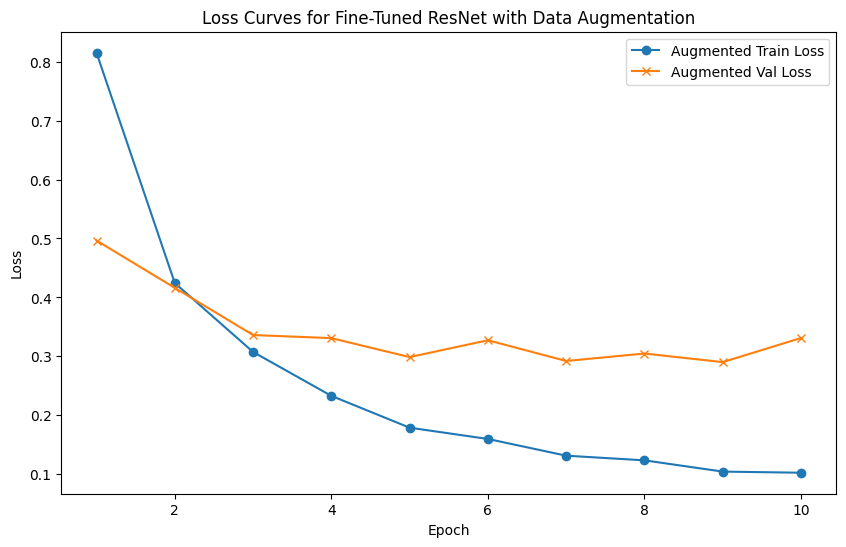

Augmented Fine-Tuned ResNet Validation Accuracy: 0.9109
Augmented Fine-Tuned ResNet Validation F1-Score: 0.9106


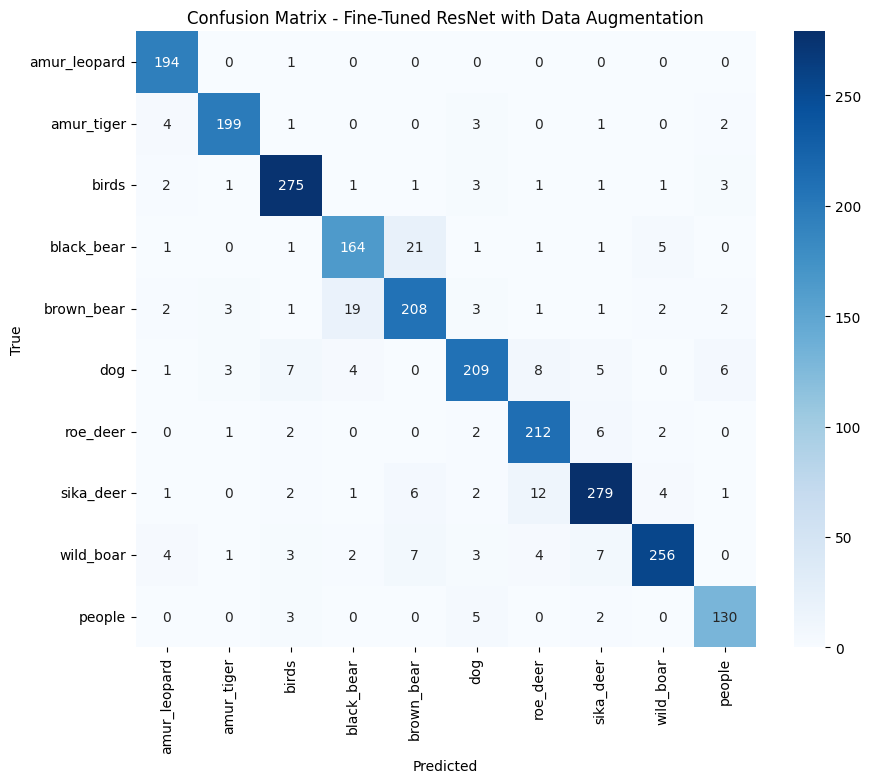

aug_resnet_f1_score,▁
aug_train_accuracy,▁▅▆▇▇▇████
aug_train_loss,█▄▃▂▂▂▁▁▁▁
aug_val_accuracy,▁▃▆▆█▇████
aug_val_loss,█▅▃▂▁▂▁▁▁▂
aug_resnet_f1_score,0.91061
aug_train_accuracy,96.41097
aug_train_loss,0.10263
aug_val_accuracy,91.08826
aug_val_loss,0.33117


In [7]:
# ---------------------------
# 4. Data Augmentation Techniques with Fine-Tuned ResNet-18
# ---------------------------

# Augmentation transform using ImageNet normalization (recommended for ResNet)
augmentation_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])

# Create the augmented training dataset and loader
train_dataset_aug = WildlifeDataset(train_paths, train_labels, transform=augmentation_transform)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=30, shuffle=True)

# For validation, we use the standard transform for ResNet (without augmentation)
# (Assuming 'transform_resnet' is defined earlier as follows:
#  transform_resnet = transforms.Compose([
#       transforms.Resize((128, 128)),
#       transforms.ToTensor(),
#       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#  ])
val_dataset_resnet = WildlifeDataset(val_paths, val_labels, transform=transform_resnet)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=30, shuffle=False)

# Define the fine-tuned ResNet-18 model (same as earlier)
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.resnet = models.ResNet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# Initialize the model, loss function, and optimizer for the augmentation task
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_aug = ResNet18(num_classes=10)
model_aug.to(device)
criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.0001)

# Initialize WandB for logging this augmentation experiment
wandb.login(key="794588cf38c96c1c7a44832a705b3af127273a99")
run = wandb.init(project="wildlife-classification-augmentation", config={
    "learning_rate": 0.0001,
    "epochs": 10,
    "batch_size": 30
})

print("Training fine-tuned ResNet-18 with data augmentation...")
epochs_aug = 10
train_losses_aug = []
val_losses_aug = []

for epoch in range(epochs_aug):
    model_aug.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)
        optimizer_aug.zero_grad()
        outputs = model_aug(images)
        loss = criterion_aug(outputs, labels)
        loss.backward()
        optimizer_aug.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase using the standard (non-augmented) validation loader
    model_aug.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader_resnet:
            images, labels = images.to(device), labels.to(device)
            outputs = model_aug(images)
            loss = criterion_aug(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_accuracy = 100 * correct_val / total_val
    avg_train_loss = running_loss / len(train_loader_aug)
    avg_val_loss = val_loss / len(val_loader_resnet)
    
    train_losses_aug.append(avg_train_loss)
    val_losses_aug.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs_aug}] - Aug: Train Loss {avg_train_loss:.4f}, Train Acc {train_accuracy:.2f}%, Val Loss {avg_val_loss:.4f}, Val Acc {val_accuracy:.2f}%")
    
    wandb.log({
        "aug_train_loss": avg_train_loss,
        "aug_train_accuracy": train_accuracy,
        "aug_val_loss": avg_val_loss,
        "aug_val_accuracy": val_accuracy
    })

# Plot training and validation loss curves for the augmentation experiment
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs_aug+1), train_losses_aug, label="Augmented Train Loss", marker="o")
plt.plot(range(1, epochs_aug+1), val_losses_aug, label="Augmented Val Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for Fine-Tuned ResNet with Data Augmentation")
plt.legend()
plt.show()

# Evaluate the model on the validation set
all_labels_aug = []
all_preds_aug = []
model_aug.eval()
with torch.no_grad():
    for images, labels in val_loader_resnet:
        images, labels = images.to(device), labels.to(device)
        outputs = model_aug(images)
        _, predicted = torch.max(outputs, 1)
        all_labels_aug.extend(labels.cpu().numpy())
        all_preds_aug.extend(predicted.cpu().numpy())

accuracy_aug = accuracy_score(all_labels_aug, all_preds_aug)
f1_aug = f1_score(all_labels_aug, all_preds_aug, average="weighted")
print(f"Augmented Fine-Tuned ResNet Validation Accuracy: {accuracy_aug:.4f}")
print(f"Augmented Fine-Tuned ResNet Validation F1-Score: {f1_aug:.4f}")

# Log and display the confusion matrix
cm_aug = confusion_matrix(all_labels_aug, all_preds_aug)
plt.figure(figsize=(10,8))
sns.heatmap(cm_aug, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(class_labels.keys()),
            yticklabels=list(class_labels.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fine-Tuned ResNet with Data Augmentation")
wandb.log({"confusion_matrix_aug_resnet": wandb.Image(plt)})
plt.show()
wandb.log({"aug_resnet_f1_score": f1_aug})

# Save the augmented model weights
torch.save(model_aug.state_dict(), "resnet_augmented_finetuned.pth")
wandb.finish()
